# Introduction

Consider a standard RCT, with the following treatment and control groups:

* The treatment group is assigned to the medical plan described [here](https://www.overcomingbias.com/2007/10/buy-health-not.html), where your "health provider" (1) can veto any treatment you want them to pay for, and (2) gets paid each year based on an evaluation of your quality of life.

* The control group is assigned to a standard medical plan, e.g. medicaid.

Assume there are $n / 2$ individuals in each group, so $n$ individuals in total.

The aim here is to determine the sample size $n$ required to gain a >80% probability of observing a statistically significant ($p < 0.05$) effect of the treatment.

I estimate the required sample size below.

First, I describe the basic model of the experiment I will use to make the sample size estimate.
Then, I estimate the "parameters" of this model - in other words, the effect size.
Last, I use the model and the parameters I came up with to estimate the required sample size.

# Assumptions

For now, let's make the following simplifying assumptions:

* Study participants all have the same baseline distribution of mortality over time, ignoring any treatments. In other words, they have the same baseline hazard function $h(t)$ over the study period (where $t = 0$ at the study start).

* The treatment helps / hurts individuals by multiplying their baseline hazard function $h(t)$ by a constant factor $r$.

For outcome data, we use two variables:
$$
D_i =
    \begin{cases}
        1 \quad \text{if individual $i$ dies during the study} \\
        0 \quad \text{otherwise} 
    \end{cases}
$$
and
$T_i$, a continuous variable representing the time at which the subject died.
(If $D_i = 0$, then we set $T_i = k$ where $k$ is the length of the study, i.e. the "censoring" time.)

We need to estimate two key quantities in order to determine the required sample size. These are:

* $p$, the probability that a given subject dies during the study.

* $r$, the hazard ratio between the two groups.

I try to estimate these in the next section.

# Parameter Estimates

## Mortality Probability $p$

According to Wikipedia, the hazard function $h(t)$ of human mortality is well-described as the sum of an exponentially increasing age-dependent component (i.e. "ageing"), and a constant age-dependent component (i.e. "random accidents").
In other words,
$$
h(t) = ae^{bt} + c
$$
for constants $a$, $b$ and $c$.

This is known as the [Gompertz-Makeham Law of Mortality](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality).

If we neglect the constant term $c$, then the probability of mortality for an individual with initial age $v$ over $k$ years is
$$
\begin{split}
p   & = 1 - \exp\left(-\int_0^k h(t) dt\right) \\
    & = 1 - \exp\left(-\frac{a_v}{b}(e^{bk} - 1)\right)
\end{split}
$$
where $a_v = a e^{bv}$ is the individual's initial hazard $h(0)$.

This paper provides many estimates of the parameters $a$ and $b$: [Models for estimating empirical Gompertz mortality: With an application to evolution of the Gompertzian slope](https://u.demog.berkeley.edu/~andrew/papers/tai_noymer_authorfinal.pdf).

## Hazard Ratio $r$

This paper gives some indication of what hazard ratio we are likely to observe: [Mortality Effects of Healthcare Supply Shocks: Evidence Using Linked Deaths and Electronic Health Records](https://www.nber.org/papers/w30553).

Here's a brief summary:

* The study used the "natural experiment" of the first Covid lockdown (in March 2020) to estimate how mortality changes when individuals are induced to consume less medicine.

* As in a normal RCT, they compare two groups: individuals who had outpatient appointments scheduled for just before and just after the start of the lockdown in March 2020.

* The "treatment" individuals experienced was an increased chance of having their appointment canceled as a result of the lockdown.

* They estimate that individuals in the treatment group had a ~5% higher mortality rate over the 12 months after their appointment (3-7% is their approximate 95% CI).

* Using the cancellation rate of appointments, they estimate that "compliers" - people who would've gone to their appointment if not for the lockdown - had a mortality rate that was around 80% higher over the 12 months after their appointment (50% - 110% is their approximate 95% CI).

* The complier group tended to be older and have more comorbidities, relative to the whole sample. (The authors speculate that doctors were more likely to cancel appointments for patients who they thought were at risk from covid.)

You might hope that they estimate the causal effect (in terms of a relative mortality risk) of an outpatient appointment "randomly" being canceled.
Or more precisely, having one outpatient appointment per year randomly canceled.
Let's call this number $r_0$.

Unfortunately, the relevant estimate they give - the relative mortality rate for compliers - overestimates $r_0$.
This is because in the study, compliers are not randomly selected. They tend to be older and have more comorbidities, relative to the sample overall.
As a result, they are comparing mortality rates between groups that differ in their age and comorbidity profiles, as well as in whether their appointments were "randomly" canceled or not.

Since most deaths in both groups are likely concentrated in older individuals with more comorbidites - so these people are the main contributor to the overall (absolute) mortality rate - I'd expect that the bias is not too severe.
Here I'll assume that the causal effect on relative mortality of having an outpatient appointment randomly canceled is 1/2 of the reported value, i.e. 40%, i.e. $r_0 = 1.4$.

Now we can ask how effective the "buy health" intervention is, relative to having an outpatient appointment randomly (not) canceled once per year.
For now, I'll consider 3 possible cases: where the "buy health" intervention is $f = 1/10, 1/3 \text{ and } 1.0$ times as effective as having an outpatient appointment randomly (not) canceled once per year.
E.g. if $f = 1/3$, and $r_0 = 1.4$, then $1/r = 1 + (1.4 - 1)/3$ or $r = 0.88$.

These 3 cases correspond to $r$ values of 0.96, 0.88 and 0.71.

# Sample Size Estimation

## Method

To estimate the sample size required to see an effect for the experiment above, we invert the [Logrank test](https://en.wikipedia.org/wiki/Logrank_test).
This test is based on the Logrank statistic, which uses both the event times $T_i$ and the indicator variables $D_i$.

Given a hazard ratio of $r$ between 2 groups, the expected number of *events* $d$ required for a one-sided test at level $\alpha$ with power $1 - \beta$ is approximately
$$
d = \frac{4(z_{\alpha} + z_{\beta})^2}{(\log r)^2}
$$
where $z_{\alpha}$ is the $\alpha$th quantile of the standard normal distribution.
See [Schoenfeld (1981)](https://www.jstor.org/stable/2335833) for a derivation.

The number of *subjects* $n$ required to see an effect is then
$$
n = \frac{d}{p}
$$
where $p$ is the probability that an individual in either group dies during the study.
$p$ can be estimated by assuming a Gompertz mortality hazard $h(t)$ as described above.

Let's use these numbers for the hazard ratio $r$:
* $r_0 = 1.4$: the causal effect (as a relative risk) of having an outpatient appointment randomly canceled once per year.
* $f = 1/10, 1/3, 1$: how effective the "buy health" plan is (in terms of its proportional hazard, assuming a proportional hazard model), relative to having an outpatient appointment randomly canceled once per year.
* $r = 1 / (1 + f(r_0 - 1)) = 0.96, 0.88, 0.71$: the hazard ratio between individuals in the treatment and control groups. E.g. if $r = 0.9$, then individuals in the treatment group have a 10% lower mortality risk than individuals in the control group at any given point in time.

And these numbers for mortality probability $p$:
* $b = (\ln 2) / 8 \approx 0.866$: mortality risk doubles every 8 years. See the paper mentioned in the previous section - also [Wikipedia](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality).
* $a = 10^{-4}$: mortality risk is around 0.3% per year at age 40, and around 10% per year by age 80 (if mortality risk doubles every 8 years). Estimates for this parameter tend to vary depending on what method you use and what country and time you're looking at (again, see paper above); most estimates are between $10^{-5}$ and $10^{-3}$.
* $v = 50$: individuals are 50 years old at the start of the study.
* $k = 20$: the study lasts 20 years.

Last, consider a test with level $\alpha = 0.05$ and power $1 - \beta = 0.8$.

Results are shown below.

## Results

In [1]:
# Libraries
from scipy.stats import norm, beta
import numpy as np
from plotnine import *

In [2]:
def compute_required_number_of_events(level, power, r):
    return 4 * (norm.ppf(level) + norm.ppf(1 - power)) ** 2 / np.log(r) ** 2

In [3]:
def compute_mortality_probability(a, b, v, k, r):
    exp = np.exp
    a_v = a * exp(b * v)
    return 1 - exp(- r * a_v / b * (exp(b * k) - 1))

In [4]:
def compute_required_sample_size(d, p):
    return d / p

In [5]:
def print_results(r, b, a, v, k, level, power):
    print(f"Computing required sample size for r = {round(r, 3)}, a = {a}, b = {round(b, 3)}, v = {v}, k = {k},  level = {level}, power = {power}")
    d = compute_required_number_of_events(level, power, r)
    p = 0.5 * compute_mortality_probability(a, b, v, k, r = 1) + 0.5 * compute_mortality_probability(a, b, v, k, r = r)
    print(f"Required events d = {np.ceil(d)}, mortality probability p = {round(p, 3)}")
    n = np.ceil(compute_required_sample_size(d, p) / 2) * 2
    print(f"Required sample size: n = {n} ({int(n/2)} per group)")

In [6]:
# Parameters
r0 = 1.4
f_list = [1/10, 1/3, 1]
r_list = [1 / (1 + f * (r0 - 1)) for f in f_list]
b = np.log(2) / 8
a = 1e-4
v = 50
k = 20
level = 0.05
power = 0.8

In [7]:
# Compute required sample size
for r in r_list:
    print_results(r = r, b = b, a = a, v = v, k = k, level = level, power = power)

Computing required sample size for r = 0.962, a = 0.0001, b = 0.087, v = 50, k = 20,  level = 0.05, power = 0.8
Required events d = 16077.0, mortality probability p = 0.33
Required sample size: n = 48650.0 (24325 per group)
Computing required sample size for r = 0.882, a = 0.0001, b = 0.087, v = 50, k = 20,  level = 0.05, power = 0.8
Required events d = 1579.0, mortality probability p = 0.319
Required sample size: n = 4944.0 (2472 per group)
Computing required sample size for r = 0.714, a = 0.0001, b = 0.087, v = 50, k = 20,  level = 0.05, power = 0.8
Required events d = 219.0, mortality probability p = 0.295
Required sample size: n = 742.0 (371 per group)


So under the assumptions above, if the "buy health" plan is 1/10 as effective as randomly having an outpatient appointment (not) canceled once per year, the required sample size is $n \simeq 50,000$. 

This decreases to $n \simeq 750$ if you assume the "buy health" plan has the same effectiveness as randomly having an outpatient appointment canceled once per year.

A middle estimate is $\sim 5000$.

A few variations on these parameters are tested at the end of this notebook.

/tmp/ipykernel_28293/2867282628.py:2: RuntimeWarning: divide by zero encountered in double_scalars


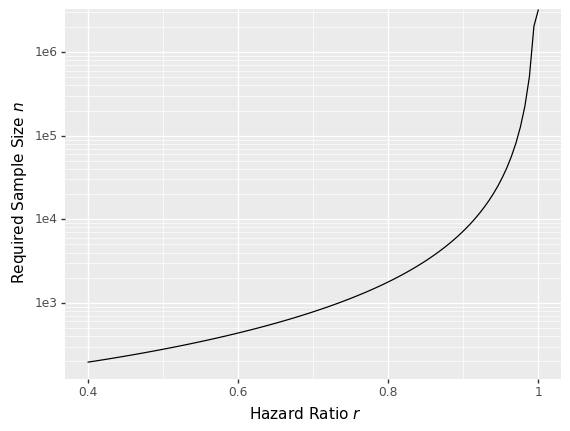

<ggplot: (8746909478663)>

In [8]:
(
    ggplot() +
        xlim(0.4, 1) +
        stat_function(fun = lambda x: compute_required_number_of_events(level, power, r = x) / compute_mortality_probability(a = a, b = b, v = v, k = k, r = x), geom="line") +
        scale_y_log10() +
        labs(x = "Hazard Ratio $r$", y = "Required Sample Size $n$")
)

# Limitations and Possible Improvements

* More precisely correct for the bias in the "mortality rate for compliers".

* Use Monte-Carlo simulation with sensible priors over all the parameters to get a better sense of the uncertainty of the estimate.

* Perform a similar estimate based on a different "quality of life" measure - e.g. self-reported health or physiological variables.

# Appendix: More Results

In [9]:
# Vary initial age
for r in r_list:
    print_results(r = r, b = b, a = a, v = 40, k = k, level = level, power = power)

Computing required sample size for r = 0.962, a = 0.0001, b = 0.087, v = 40, k = 20,  level = 0.05, power = 0.8
Required events d = 16077.0, mortality probability p = 0.155
Required sample size: n = 103574.0 (51787 per group)
Computing required sample size for r = 0.882, a = 0.0001, b = 0.087, v = 40, k = 20,  level = 0.05, power = 0.8
Required events d = 1579.0, mortality probability p = 0.149
Required sample size: n = 10566.0 (5283 per group)
Computing required sample size for r = 0.714, a = 0.0001, b = 0.087, v = 40, k = 20,  level = 0.05, power = 0.8
Required events d = 219.0, mortality probability p = 0.137
Required sample size: n = 1598.0 (799 per group)


In [10]:
# Vary study length and initial age
for r in r_list:
    print_results(r = r, b = b, a = a, v = 60, k = 10, level = level, power = power)

Computing required sample size for r = 0.962, a = 0.0001, b = 0.087, v = 60, k = 10,  level = 0.05, power = 0.8
Required events d = 16077.0, mortality probability p = 0.246
Required sample size: n = 65340.0 (32670 per group)
Computing required sample size for r = 0.882, a = 0.0001, b = 0.087, v = 60, k = 10,  level = 0.05, power = 0.8
Required events d = 1579.0, mortality probability p = 0.237
Required sample size: n = 6654.0 (3327 per group)
Computing required sample size for r = 0.714, a = 0.0001, b = 0.087, v = 60, k = 10,  level = 0.05, power = 0.8
Required events d = 219.0, mortality probability p = 0.218
Required sample size: n = 1002.0 (501 per group)


The required sample size decreases rapidly with age. This reflects the fact that the baseline risk increases exponentially with age, and the level of "risk-reduction" is modeled as a fraction of the baseline risk.

# Appendix: Bayesian Approach

An alternative approach is to use a Bayesian analysis to compute a distribution of beliefs over the possible required sample size.

In this approach, you first estimate belief distributions over the model parameters ($r$ and $p$), and use these to compute the corresponding distribution over the sample size $n$ required for a test of power $1 - \beta$ at level $\alpha$.

Here I'll focus on the prior distribution over $r$, since this is probably the main source of uncertainty in the estimates above.
And I'll consider a prior for $r$ conditional on $r \lt 1$, i.e. conditional on the treatment being effective.
(Otherwise it doesn't make sense to estimate a sample size.)

What prior over $r$ is appropriate?
I'll look for a prior based on these assumptions:

* Our median expectation is $r \simeq 0.9$, roughly the middle estimate suggested above.

* There is $\simeq 5\%$ probability that the treatment more than halves the mortality rate of individuals, i.e. $r \lt 0.5$.

A distribution which roughly satisfies these conditions is shown below.

The 5%, 50% and 95% quantiles for r are [0.55656527 0.86735506 0.98749045] respectively


/home/chris/.mambaforge/envs/play/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 47'. Pick better value with 'binwidth'.


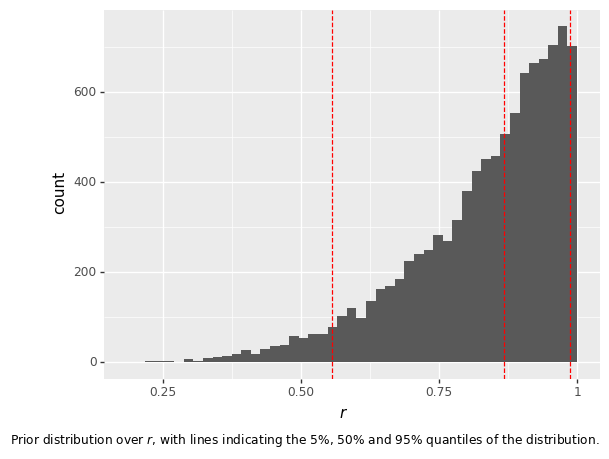

<ggplot: (8746900920816)>

In [11]:
beta_params = {"a": 5.5, "b": 1.1}

r_prior = beta.rvs(size = 10000, **beta_params)

r_quantiles = np.quantile(r_prior, [0.05, 0.5, 0.95])

print(f"The 5%, 50% and 95% quantiles for r are {r_quantiles} respectively")
(
    ggplot(mapping = aes(x = r_prior))+
        geom_histogram(boundary=1) +
        geom_vline(xintercept = r_quantiles, colour = "red", linetype = "dashed") +
        labs(x = "$r$", caption = "Prior distribution over $r$, with lines indicating the 5%, 50% and 95% quantiles of the distribution.")
)

It is then simple to translate this into a distribution over $n$, the required sample size.

The 5%, 50% and 95% quantiles for n are [3.53725493e+02 4.08841221e+03 4.69595654e+05] respectively


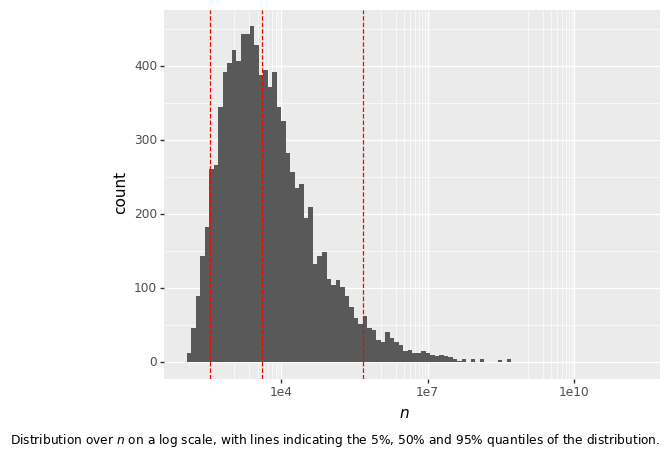

<ggplot: (8746909415500)>

In [12]:
n_prior = compute_required_sample_size(d = compute_required_number_of_events(level=level, power=power, r=r_prior), p = compute_mortality_probability(a = a, b = b, v = v, k = k, r=r_prior))

n_quantiles = np.quantile(n_prior, [0.05, 0.5, 0.95])

print(f"The 5%, 50% and 95% quantiles for n are {n_quantiles} respectively")
(
    ggplot(mapping = aes(x = n_prior))+
        geom_histogram(bins = 100) +
        geom_vline(xintercept = n_quantiles, colour = "red", linetype = "dashed") +
        scale_x_log10() +
        labs(x = "$n$", caption = "Distribution over $n$ on a log scale, with lines indicating the 5%, 50% and 95% quantiles of the distribution.")
)